In [19]:
!conda list dolfin
!conda list mshr

# packages in environment at /home/wsl-20/anaconda3/envs/fenics-top-workspace:
#
# Name                    Version                   Build  Channel
mshr                      2019.1.0        py312h5909d04_10    conda-forge


In [20]:
from dolfin import *
import numpy as np
# import pygad
import pyswarms as ps
import matplotlib.pyplot as plt
import mshr as mr

set_log_level(50)

vertex number: 609
cell number: 1072


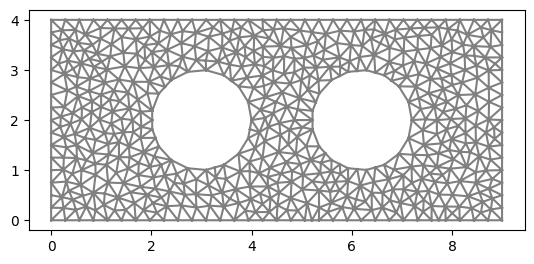

In [21]:
# 创建网格
rectangle = mr.Rectangle(Point(0.0, 0.0), Point(9.0, 4.0))
hole_1 = mr.Circle(Point(3.0, 2.0), 1)
hole_2 = mr.Circle(Point(6.2, 2.0), 1)
domain = rectangle - hole_1 - hole_2

# 创建网格
mymesh = mr.generate_mesh(domain, 24)
vertex_num = mymesh.num_vertices()
cell_num = mymesh.num_cells()
plot(mymesh)
print(f"vertex number: {vertex_num}")
print(f"cell number: {cell_num}")

In [22]:
# 初始化
nelx, nely = 10, 10
# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800
# 转动角度
Theta = 0
Theta_init = 5
# 载荷
forcing = Constant((0, 500))

# 弹性张量
C2D_Iso = np.array([
    [E1/(1-mu12**2),        mu12*E2/(1-mu12**2),         0  ],
    [mu12*E2/(1-mu12**2),   E2/(1-mu12**2),              0  ],
    [0,                     0,                           G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    c = cos(theta)
    s = sin(theta)
    Trans = np.array([
        [c**2,  s**2,   -2*s*c],
        [s**2,  c**2,   2*s*c],
        [s*c,   -s*c,   c**2 - s**2]
    ])
    return Trans

# 准备网格
mesh = UnitSquareMesh(nelx, nely)
V = VectorFunctionSpace(mesh, "CG", 1)
T = FunctionSpace(mesh, "DG", 0)
u_sol = Function(V)
Theta_sol = Function(T)
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [23]:
# 定义物理方程
# 物理方程
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

# 本构方程
def sigma_tensor(u, Theta_Ev):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    Q_bar = np.dot(np.dot(T2D_inv(Theta_Ev), C2D_Iso), T2D_inv(Theta_Ev).T)
    sigma_ij = np.dot(Q_bar, ep)

    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

# 弹性能密度
def psi(u, Theta):
    return 0.5 * inner(sigma_tensor(u, Theta), epsilon(u))

In [24]:
# 定义边界
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < DOLFIN_EPS

bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS and (abs(x[1] - 0.5) < 0.1)
right_end_boundary = RightEnd()

class TopEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 0.5) < 0.5 and (abs(x[1] - 1) < DOLFIN_EPS)
top_end_boundary = TopEnd()

boundary_mark = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)
top_end_boundary.mark(boundary_mark, 2)

In [25]:
# 有限元求解
def FEA(V:VectorFunctionSpace, lhs, rhs, u:Function, bc:DirichletBC) -> Function: 
    problem = LinearVariationalProblem(lhs, rhs, u, bc)
    solver = LinearVariationalSolver(problem)
    return solver.solve()

In [26]:
# 可视化
def plot_theta_vector(theta:Function, mesh, scale=30, width=0.001):
    theta_rad = np.deg2rad(Theta_sol.vector()[:])  # 将角度转换为弧度
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    # 将二维向量表示合并为一个二维数组
    vector_values = np.vstack((x_values, y_values)).T  # 转置使每行是一个向量
    # 获取网格的中心点
    cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
    # 提取中心点的坐标
    x_coords = np.array([p.x() for p in cell_midpoints])
    y_coords = np.array([p.y() for p in cell_midpoints])
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    # 可视化向量场
    plt.figure()
    plot(mesh)
    # plt.quiver(x_coords, y_coords, u, v)
    # 绘制正方向的箭头
    plt.quiver(x_coords, y_coords, u, v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')
    # 绘制反方向的箭头
    # plt.quiver(x_coords, y_coords, -u, -v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')

    plt.title("Vector field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

In [27]:
# 定义优化问题
def minimize_strain_energy(x):
    # 将 PSO 粒子的位置 x 映射到每个单元格的转动角度
    theta_values = x[:, :T.dim()]
    total_energy = []
    for i in range(theta_values.shape[0]):
        theta_func = Function(T)
        theta_func.vector()[:] = theta_values[i, :]
        Theta_sol.assign(theta_func)
        lhs = inner(sigma_tensor(u_trial, Theta_sol), nabla_grad(v_test)) * dx
        rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mesh, subdomain_id=2)
        FEA(V, lhs, rhs, u_sol, bc)
        energy_density = assemble(psi(u_sol, Theta_sol) * dx)
        total_energy.append(energy_density)
    return np.array(total_energy)

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=T.dim(), options=options)

# Perform optimization
cost, pos = optimizer.optimize(minimize_strain_energy, iters=500)


2024-07-29 19:46:53,718 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=8.21
2024-07-29 19:49:29,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.214044292499286, best pos: [ 25.66263407   6.6184757   22.23321697  -0.61315984  19.59937338
  -9.99326662   5.59023166  16.0035844   27.88357955  25.5632732
  11.5650799   13.44620378  28.67227041  16.91642713  -3.61066824
  14.53724049  13.87694658  20.36262876  -4.79159657  -1.78931303
   0.45397688 -14.19783652  -5.54032265  29.83888536  -5.47183106
  14.38272787  18.70538825  20.66945099  -6.25338903   6.39520819
  10.1003916   15.1891744    6.58009148  -3.74803288   6.39203889
   1.20994082   1.88540914   6.83328734  16.44691242   0.95635557
  31.5667182   -1.94785192  11.45544714  12.98273989  21.86503365
  10.80855433  -1.7160889    1.7681623   14.07288617  13.12772056
   1.9174243    3.030

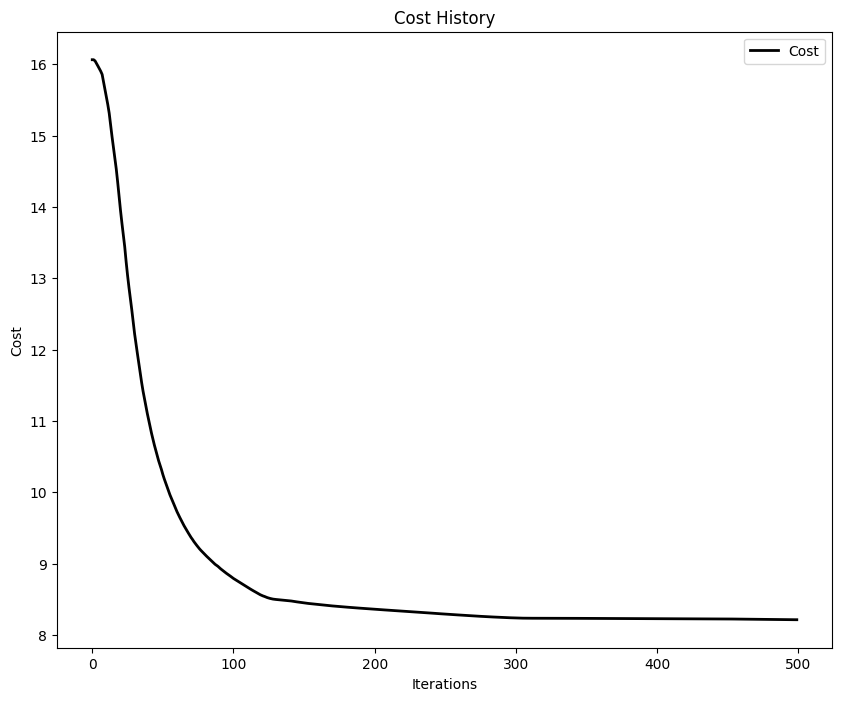

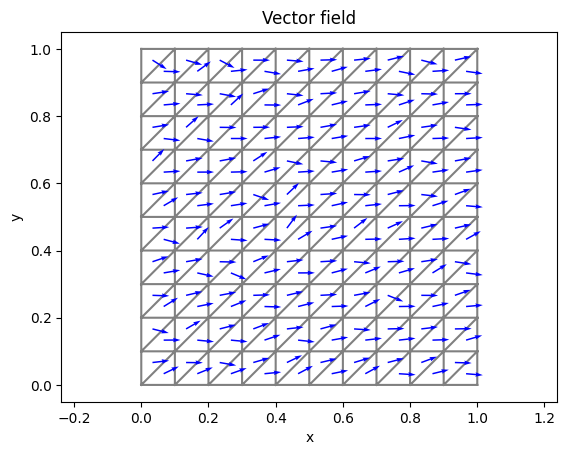

In [28]:
# 可视化
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

Theta_sol.vector()[:] = pos
plot_theta_vector(Theta_sol, mesh=mesh, scale=20, width=0.003)

plt.show()

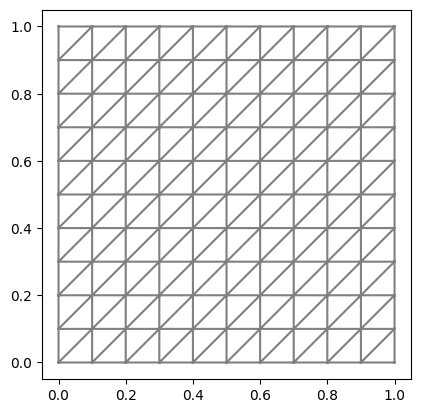

In [29]:
plot(mesh)